# Recommender system
this project covers a buisness problem based out for a food delivery app where task is to recommend person with best vendor who fits for there purhase past or spending habits based out on various parameters

the dataset for this case study can be obtained  [from here](https://github.com/samyakpshetty/DA-Project-Restaurant-Recommendaton-System)

here we are given with various csv file each having specific values such as customers.csv is having values which are relevant to predict customers purchase, vendors tell about vendor rating, products they catter and order.csv acts as joining table that can be used to join all csv files and create a new matrix

## Loading important library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import mktime
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics.pairwise import haversine_distances
from math import radians,sqrt
from tqdm import tqdm
from surprise import Reader, Dataset, BaselineOnly ,SVDpp, KNNBaseline
from tensorflow.test import gpu_device_name
import pickle
from sklearn.metrics import mean_squared_error,make_scorer
from statistics import mode
import warnings
warnings.filterwarnings('ignore')

In [3]:
GPU=1 if gpu_device_name()=='/device:GPU:0' else 0

2022-05-30 09:27:04.756222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 09:27:04.806945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:27:04.894332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:27:04.895128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Data preprocessing and E.D.A.

### Vendors.CSV

In [4]:
vendors=pd.read_csv("/kaggle/input/restaurant-recommendation-challenge/vendors.csv")
vendors.head(2)

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1


In [5]:
print('Unique languages present in Vendors.CSV are            {}'.format(vendors['language'].unique()))
print('Unique display_orders present in Vendors.CSV are       {}'.format(vendors['display_orders'].unique()))
print('Unique city_is present in Vendors.CSV are              {}'.format(vendors['city_id'].unique()))
print('Unique country_id present in Vendors.CSV are           {}'.format(vendors['country_id'].unique()))
print('Unique open_close_flags present in Vendors.CSV are     {}'.format(vendors['open_close_flags'].unique()))
print('Unique commission present in Vendors.CSV are           {}'.format(vendors['commission'].unique()))
print('Unique is_akeed_delivering present in Vendors.CSV are  {}'.format(vendors['is_akeed_delivering'].unique()))
print('Unique one_click_vendor present in Vendors.CSV are     {}'.format(vendors['one_click_vendor'].unique()))
print('Unique device_type present in Vendors.CSV are          {}'.format(vendors['device_type'].unique()))
print('Unique ranks present in Vendors.CSV are                {}'.format(vendors['rank'].unique()))


Unique languages present in Vendors.CSV are            ['EN' nan]
Unique display_orders present in Vendors.CSV are       [1]
Unique city_is present in Vendors.CSV are              [1.]
Unique country_id present in Vendors.CSV are           [1.]
Unique open_close_flags present in Vendors.CSV are     [1.]
Unique commission present in Vendors.CSV are           [ 0. nan]
Unique is_akeed_delivering present in Vendors.CSV are  ['Yes']
Unique one_click_vendor present in Vendors.CSV are     ['Y']
Unique device_type present in Vendors.CSV are          [3 1]
Unique ranks present in Vendors.CSV are                [11  1]


In [6]:
vendors['status'].unique(),vendors['status'][vendors['status']==1].count()#here we cannot drop this feature as value of 0 are also significant
vendors['is_open'].unique(),vendors['is_open'][vendors['is_open']==1].count()#significant value of 0 are present

(array([1., 0.]), 85)

In [7]:
#all these columns just comprise of single value thus they make no significant effect and thus can be removed to free some memory
vendors.drop(['language','display_orders','device_type','city_id','country_id','open_close_flags','commission','is_akeed_delivering','one_click_vendor'],axis=1,inplace=True)

vendors.drop(['OpeningTime','OpeningTime2'],axis=1,inplace=True)#these values can just be obtained from day wise timings given 

vendors.drop('vendor_tag',axis=1,inplace=True)# This feature is just a replica of feature vendor_tag_name

In [8]:
'''
idea=when observed almost all weekdays has same open and close time for a single marked restaurants where as all weekends were almost same thus drop all other and keep values of one week day and one weekend
'''

vendors.drop(['thursday_from_time1','thursday_from_time2','thursday_to_time1','thursday_to_time2'],axis=1,inplace=True)
vendors.drop(['wednesday_from_time1','wednesday_from_time2','wednesday_to_time1','wednesday_to_time2'],axis=1,inplace=True)
vendors.drop(['monday_from_time1','monday_from_time2','monday_to_time1','monday_to_time2'],axis=1,inplace=True)
vendors.drop(['sunday_from_time1','sunday_from_time2','sunday_to_time1','sunday_to_time2'],axis=1,inplace=True)
vendors.drop(['friday_from_time1','friday_from_time2','friday_to_time1','friday_to_time2'],axis=1,inplace=True)

In [9]:
def tagssort(x):
  '''
  primary tags are given in form of {"primary_tags":"0"} this function wil convert them to int 0 or whhatever value is present
  '''
  a=x.split(":")[1]
  return int(a.split('"')[1])
vendors['primary_tags'].fillna('{"primary_tags":"0"}',inplace=True)
vendors['primary_tags']=vendors['primary_tags'].apply(tagssort)

In [10]:
vendors.rename(columns={'tuesday_from_time1':'weekdaytime1','tuesday_from_time2':'weekdaytime2','tuesday_to_time1':'weekdayclose1','tuesday_to_time2':'weekdayclose2'},inplace=True)
vendors.rename(columns={'saturday_from_time1':'weekendtime1','saturday_from_time2':'weekendtime2','saturday_to_time1':'weekendclose1','saturday_to_time2':'weekendclose2'},inplace=True)

In [11]:
vendors.weekdaytime1.fillna('00:01:00',inplace=True)
vendors.weekdaytime2.fillna('11:00:00',inplace=True)
vendors.weekdayclose1.fillna('23:45:00',inplace=True)
vendors.weekdayclose2.fillna('23:59:00',inplace=True)
vendors.weekendtime1.fillna('00:01:00',inplace=True)
vendors.weekendtime2.fillna('08:00:00',inplace=True)
vendors.weekendclose1.fillna('23:45:00',inplace=True)
vendors.weekendclose2.fillna('23:59:00',inplace=True)

In [12]:
vendors['rank']=vendors['rank'].replace({1:0,11:1}) #replacing rank 11 with 1 and 1 with 0

In [13]:
vendors.rename(columns={'id':'vendor_id'},inplace=True)

In [14]:
#this snippet shows null value in each column
for i in vendors.columns:
  if vendors[i].isnull().sum(axis=0)>0:
    print(vendors[i].isnull().sum(axis=0),i)

3 vendor_tag_name


In [15]:
vendors.to_csv("vendor_prep")

### Customers.CSV

In [16]:
customers=pd.read_csv("/kaggle/input/restaurant-recommendation-challenge/train_customers.csv")
customers.columns,customers.shape

(Index(['akeed_customer_id', 'gender', 'dob', 'status', 'verified', 'language',
        'created_at', 'updated_at'],
       dtype='object'),
 (34674, 8))

In [17]:
print(customers['status'][customers['status']==0].count())
#as status feature is extremely imbalanced with just 35 feature as 0 whereas 34500 as 1 i belive it can be removed but to remove this we need to discard value with exception ie status=0
i=customers.index[ customers.loc[:,'status'] == 0]
customers.drop(i,inplace=True)
customers.drop('status',axis=1,inplace=True)

35


In [18]:
customers.gender.fillna('notgiven',inplace=True)#gender can be a imp feature of concern so we just cant fill it in either gender and better is to assign them new gender 

In [19]:
customers.drop('language',axis=1,inplace=True)#single value en
customers.drop('created_at',axis=1,inplace=True)#almost same as verified at and places where these are not identical there also verified_at is passing more imp information

In [20]:
customers.drop('dob',axis=1,inplace=True)# almost 80% values are NaN and this cannot be forged as it might be an important parameter
customers.rename(columns={'akeed_customer_id':'customer_id'},inplace=True)

In [21]:
location=pd.read_csv('/kaggle/input/restaurant-recommendation-challenge/train_locations.csv')
location.columns

Index(['customer_id', 'location_number', 'location_type', 'latitude',
       'longitude'],
      dtype='object')

In [22]:
location['location_type'].fillna('Other',inplace=True)

In [23]:
for i in location.columns:
  print(location[i].isnull().sum(axis=0),i)
location.shape

0 customer_id
0 location_number
0 location_type
6 latitude
6 longitude


(59503, 5)

In [24]:
location.dropna(inplace=True)

In [25]:
consumer=pd.merge(customers,location,on='customer_id')#merge customer and location to form consumer

In [26]:
for i in consumer.columns:
  print(consumer[i].isnull().sum(axis=0),i)
consumer.shape

0 customer_id
0 gender
0 verified
0 updated_at
0 location_number
0 location_type
0 latitude
0 longitude


(58146, 8)

In [27]:
def gender(x):
    '''
    values in gender were of class "Male","Male  ","male " so this function brings them to base
    '''
    try:
      x1=x.split(" ")[0]
      x1=x1.lower()
      return x1
    except:
      return np.nan
consumer.gender=consumer.gender.apply(gender)

In [28]:
consumer.gender[consumer.gender==''].count()

3

### Orders.CSV

In [29]:
orders=pd.read_csv('/kaggle/input/restaurant-recommendation-challenge/orders.csv')
orders.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [30]:
orders['promo_code'].fillna(0,inplace=True)
#i dont need promo code instead it would be better to get weather promo code is being applied or not
i=orders.index[orders.loc[:,'promo_code'] != 0]
orders['promo_code'][i]=1

<AxesSubplot:xlabel='is_rated', ylabel='Count'>

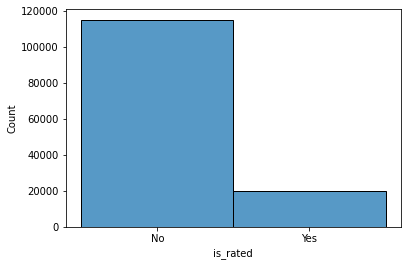

In [31]:
sns.histplot(orders.is_rated)

In [32]:
orders.vendor_rating[orders.is_rated=='No'].describe()

count    25111.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: vendor_rating, dtype: float64

In [33]:
#if a order is not rated then it is having either NaN values or 0 as rating and since our rating is main value we are using to compare.
i=orders.index[orders.loc[:,'is_rated'] == 'No']
orders.drop(i,inplace=True)
orders.drop('is_rated',axis=1,inplace=True)

In [34]:
orders['delivery_date'].isnull().sum(axis=0)

19670

as most delivery dates are null we need to drop this and post here we cannot predict any temporal nature

In [35]:
def minutes(x):
  x1=x.split(" ")[1]
  #print(x1)
  if x1.split(":")[0]=='0':
    k=np.nan
  elif (x1.split(":")[0]=='00'):
    k=13*3600+int(x1.split(":")[1])*60+int(x1.split(":")[2])
  else:
    k=int(x1.split(":")[0])*3600+int(x1.split(":")[1])*60+int(x1.split(":")[2])
  return k
orders.order_accepted_time.fillna('0 0:0',inplace=True)
orders['order_accepted_time']=orders.order_accepted_time.apply(minutes)
orders.delivered_time.fillna('0 0:0',inplace=True)
orders['delivered_time']=orders['delivered_time'].apply(minutes)
orders['time_taken']=abs(orders['delivered_time']-orders['order_accepted_time'])
orders.time_taken.fillna(orders.time_taken.median(),inplace=True)

In [36]:
#I doubt that there can be no 0 ratings as usually ratings start from 1-5 or 1-10
i=orders.index[orders.loc[:,'vendor_rating'] == 0]
orders.drop(i,inplace=True)

In [37]:
orders.promo_code_discount_percentage.fillna(0,inplace=True)

In [38]:
orders.is_favorite.fillna('No',inplace=True)

In [39]:
orders.item_count.fillna(orders.item_count.median(),inplace=True)

In [40]:
orders.drop(['order_accepted_time', 'driver_accepted_time','ready_for_pickup_time', 'picked_up_time', 'delivered_time'],axis=1,inplace=True)

### Merging All to form df final

In [41]:
delivered=pd.merge(consumer,orders,on='customer_id')
final=pd.merge(delivered,vendors,on='vendor_id')

In [42]:
#calculate haversine distance between vendor and consumer


distx=[];disty=[]
distance=[]
for i in range(len(final)):
  distx.append([final['latitude_x'].iloc[i],final['longitude_x'].iloc[i]])
  disty.append([final['latitude_y'].iloc[i],final['longitude_y'].iloc[i]])
for i in range(len(distx)):
  xinrad=[radians(_) for _ in distx[i]]
  yinrad=[radians(_) for _ in disty[i]]
  result = haversine_distances([xinrad, yinrad])
  distance.append(np.max(result))

final['dist']=distance
del distx,disty,distance

In [43]:
final.drop(['latitude_x','latitude_y','longitude_x','longitude_y','vendor_category_en','verified_x', 'driver_rating','created_at_x', 'updated_at_x','akeed_order_id','preparationtime', 'delivery_time', 'delivery_date','created_at_y', 'LOCATION_NUMBER', 'CID X LOC_NUM X VENDOR', 'LOCATION_TYPE','authentication_id',  'updated_at_y'],axis=1,inplace=True)

In [44]:
final.drop_duplicates(inplace=True)

In [45]:
items=[];counts=[]
def tagfind(x):
  global items
  global counts
  try:
    x1=x.split(",")
    #x1=x
    for i in x1:
      if i not in items:
        items.append(i)
    for i in range(len(items)):
      if items[i] in x1:
        counts.append(i)
  except:
    x1=x
  return x1
final.vendor_tag_name.fillna('Desserts,Sandwiches, Burgers',inplace=True)
final.vendor_tag_name=final.vendor_tag_name.apply(tagfind)

In [46]:
def drinks(x):
  try:
    if ('Milkshakes' or 'Mojitos' or 'Fresh Juices' or 'Ice creams' or 'Coffee' or 'Smoothies' or 'Hot Chocolate' or 'Cafe' or 'Frozen yoghurt') in x:
      return 1
    else:
      return 0
  except:
    pass
final['shakes']=final.vendor_tag_name.apply(drinks)

In [47]:
items=set(items)-{'Milkshakes', 'Mojitos', 'Fresh Juices', 'Ice creams', 'Coffee', 'Smoothies' ,'Hot Chocolate' ,'Cafe', 'Frozen yoghurt'}

In [48]:
for i in final.columns:
  if final[i].isnull().sum(axis=0)>0:
    print(final[i].isnull().sum(axis=0),i)
final.shape

(55374, 37)

In [49]:
cust_id=[]
def convert(x):
  '''
  convert customer id that is string in integer based on referencing in list
  '''
  global cust_id
  if x not in cust_id:
    cust_id.append(x)
  return cust_id.index(x)
final.customer_id = final.customer_id.apply(convert)

### One hot encoding

In [50]:
genderDummy=pd.get_dummies(final['gender'],prefix='gender')
loc_noDummy=pd.get_dummies(final['location_number'],prefix='locnumb')
loc_type=pd.get_dummies(final['location_type'],prefix='loctype')
final.is_favorite.replace({'Yes':1,'No':0},inplace=True)

In [51]:
final1=pd.concat([final,genderDummy,loc_noDummy,loc_type],axis=1)
final1.drop(['weekendtime1','weekendtime2','weekendclose1','weekendclose2','weekdaytime1','weekdaytime2','weekdayclose1','weekdayclose2','gender','location_number','location_type'],axis=1,inplace=True)
final1.dropna(inplace=True)

In [52]:
len(final1.vendor_id.unique())

100

In [53]:
for i in items:
  final1[i]=0
for j in tqdm(range(len(final1))):
  for i in items:
    if i in final1.vendor_tag_name.iloc[j]:
      final1[i].iloc[j]=1

100%|██████████| 55374/55374 [02:59<00:00, 308.69it/s]


In [54]:
final1.drop('vendor_tag_name',axis=1,inplace=True)

## EDA

[Text(0.5, 1.0, 'delivery distanace providedin KM')]

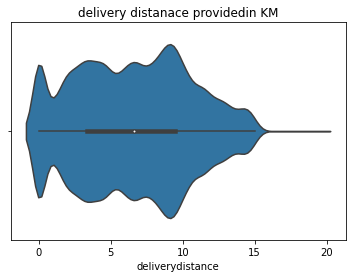

In [55]:
sns.violinplot(final1.deliverydistance).set(title="delivery distanace providedin KM")

[Text(0.5, 1.0, 'hevsine distbetweeen venodor and consumer in KM')]

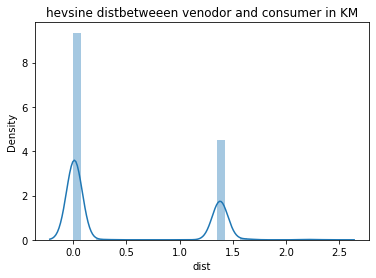

In [56]:
sns.distplot(final.dist).set(title="hevsine distbetweeen venodor and consumer in KM")

haversine distance doesnt seems valuable so we may either drop them or wait for feature importance plot

[Text(0.5, 1.0, 'vendor_rating given per order by customer')]

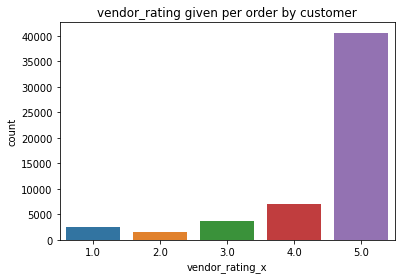

In [57]:
sns.countplot(final['vendor_rating_x']).set(title='vendor_rating given per order by customer')

[Text(0.5, 1.0, 'This is avg past rating given to vendor')]

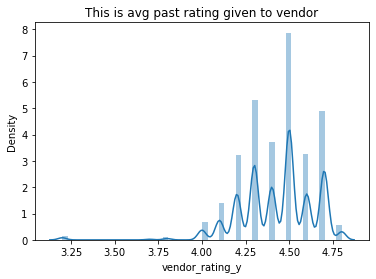

In [58]:
sns.distplot(final.vendor_rating_y).set(title='This is avg past rating given to vendor')

In [59]:
final1.vendor_rating_x.mean() #global averge rating given by consumer

4.471051395962004

In [60]:
final1.deliverydistance.mean() #global averge distance for the food ordered

6.539241882471918

[Text(0.5, 1.0, 'prepration time per order')]

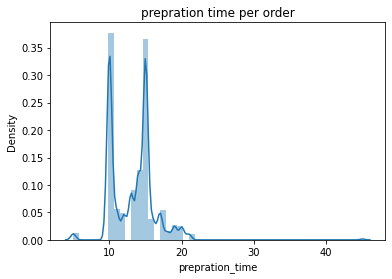

In [61]:
sns.distplot(final.prepration_time).set(title='prepration time per order') #food time taken to complete prepration

<AxesSubplot:xlabel='is_favorite', ylabel='Count'>

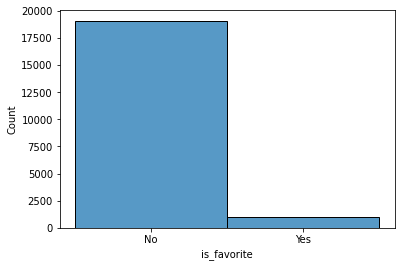

In [62]:
sns.histplot(orders.is_favorite) #shows usually people just not order food from here fav vendor

<AxesSubplot:xlabel='gender', ylabel='count'>

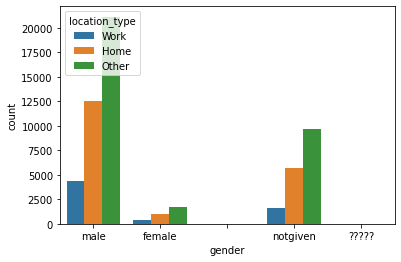

In [63]:
sns.countplot(consumer['gender'],hue=consumer['location_type'])

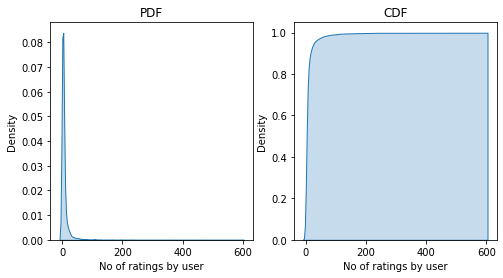

In [64]:
food_ordered_per_user = final.groupby(by='customer_id')['vendor_rating_x'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(food_ordered_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(food_ordered_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

these can be students or bachelors who usually order food regularly

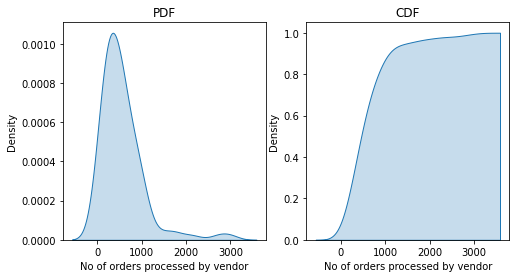

In [65]:
venor_gets_orders = final.groupby(by='vendor_id')['vendor_rating_x'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(venor_gets_orders, shade=True, ax=ax1)
plt.xlabel('No of orders processed by vendor')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(venor_gets_orders, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of orders processed by vendor')
plt.title('CDF')

plt.show()

this shows that max vendor get about 1000 orders in this time frame thus there is no such bias and dataset is healthy


## Hyperparameter Tuning

In [66]:
def hyperpara(x,y):
  start=datetime.now()
  if GPU:
      estimator = XGBRegressor(random_state=15,tree_method='gpu_hist', gpu_id=0)
  if GPU==0:
      estimator = XGBRegressor(random_state=15,)

  parameters = {'learning_rate': [0.01,0.02],'n_estimators' : [600,800],'max_depth' : [6,8]}

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
  def RMSE_hyp(y_true,y_pred):
      mse = mean_squared_error(y_true, y_pred)
      return sqrt(mse)

  grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,scoring = make_scorer(RMSE_hyp, greater_is_better=False) ,n_jobs = -1,cv = 3,verbose=True)
  grid_search.fit(x,y)
  stop=datetime.now()-start
  print('time required to tune hyperparamter    ',stop)
  print('*'*100)
  print(grid_search.best_estimator_)
  print("*"*100)
  return grid_search.best_estimator_


## Content based Recommendation

In [67]:
def regressor(X_train, X_test, y_train, y_test,name,imp_plot=True):
  start=datetime.now()

  xgb_r = hyperpara(X_train,y_train)

  # Fitting the model
  eval_set = [(X_train, y_train), (X_test, y_test)]
  xgb_r.fit(X_train, y_train, eval_set=eval_set,verbose=False)
  
  #plotting
  results = xgb_r.evals_result()
  epochs = len(results['validation_0']['rmse'])
  x_axis = range(0, epochs)
  # plot log loss
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
  ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
  ax.legend()
  plt.ylabel('RMSE')
  plt.title('XGBoost RMSE train test graph')
  plt.show()

  # Predict the model
  pred = xgb_r.predict(X_test)
  pred1=xgb_r.predict(X_train)
  RMSE=0;RMSE1=0
  for i in range(len(pred)):
    RMSE+=(y_test.iloc[i]-pred[i])**2
    RMSE1+=(y_train.iloc[i]-pred1[i])**2
  RMSE/=len(pred)
  RMSE1/=len(pred)
  RMSE=sqrt(RMSE)
  RMSE1=sqrt(RMSE1)
  rmse[name]=[RMSE1,RMSE]
  def roundoff(x):
    return np.around(x,2)
  if imp_plot:
    result=pd.DataFrame()
    result['y_acc']=y_test
    result['y_pred']=xgb_r.predict(X_test)
    result['y_pred']=result['y_pred'].apply(roundoff)
    result['error']=abs(result.y_pred-result.y_acc)
    sns.distplot(result.error)
    plt.show()
    print("-"*100)
    fig, ax = plt.subplots(figsize=(10, 20))
    plot_importance(xgb_r,ax=ax)
    plt.show()
  
  with open(name+'.pkl', 'wb') as handle:
    pickle.dump(xgb_r, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print(datetime.now()-start)
  print('-'*100)
  return [RMSE1,RMSE]

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:04:07.580999
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


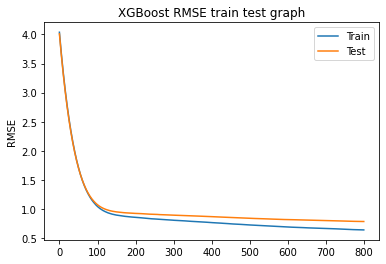

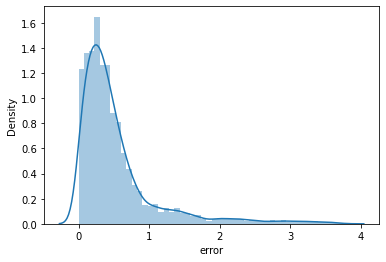

----------------------------------------------------------------------------------------------------


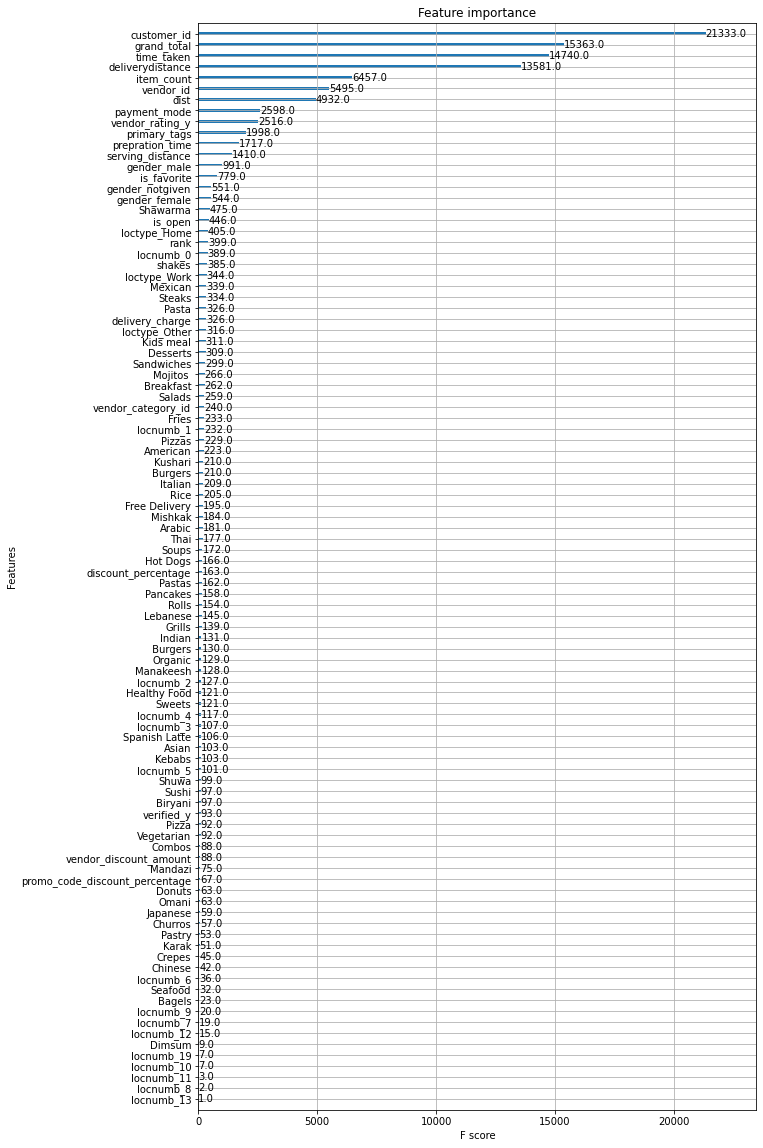

0:04:24.425395
----------------------------------------------------------------------------------------------------


[0.6452332043639201, 0.7880284038981112]

In [68]:
rmse=dict()

X_train, X_test, y_train, y_test = train_test_split(final1.drop('promo_code',axis=1), final1.vendor_rating_x, test_size=0.20,random_state=15)
regressor(X_train.drop('vendor_rating_x',axis=1), X_test.drop('vendor_rating_x',axis=1), y_train, y_test ,'raw model',True)

## Adding some features based on collaborative filtering of customer_id, vendor_id and rating

### adding features using Surprise library

In [69]:
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(X_train[['customer_id', 'vendor_id', 'vendor_rating_x']], reader)
trainset = train_data.build_full_trainset() 

#we are just adding both as we
testset = list(zip(X_test.customer_id.values, X_test.vendor_id.values, X_test.vendor_rating_x.values))
testset[:3]

models_evaluation_train = dict()
models_evaluation_test = dict()


In [70]:
import random
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

### Regression with xgboost and baselinemodel

In [71]:
bsl_options = {'method': 'sgd',
               'learning_rate': .1
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=False)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.181204 

Evaluating the model with train data..
time taken : 0:00:00.283954

Evaluating for test data...
time taken : 0:00:00.069134

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.534933


In [72]:
X_train['bslpr']=models_evaluation_train['bsl_algo']['predictions']
X_test['bslpr']=models_evaluation_test['bsl_algo']['predictions']

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:04:06.086093
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


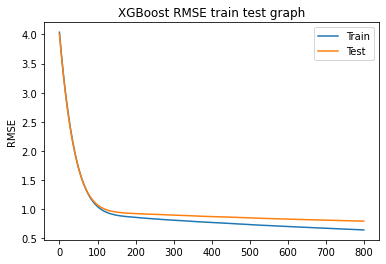

0:04:20.797905
----------------------------------------------------------------------------------------------------


[0.6508886768436781, 0.7964104571409063]

In [73]:
regressor(X_train.drop('vendor_rating_x',axis=1), X_test.drop('vendor_rating_x',axis=1), y_train, y_test ,'baseline model',False)

### Regression with xgboost and surprise SVD

In [74]:
svdpp = SVDpp(n_factors=60, random_state=15, verbose=False)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=False)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
Done. time taken : 0:01:24.997072 

Evaluating the model with train data..
time taken : 0:00:03.725829

Evaluating for test data...
time taken : 0:00:01.141399

---------------------------------------------
Total time taken to run this algorithm : 0:01:29.864687


In [75]:
X_train['svdpp']=models_evaluation_train['svdpp']['predictions']
X_test['svdpp']=models_evaluation_test['svdpp']['predictions']

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:04:07.099847
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


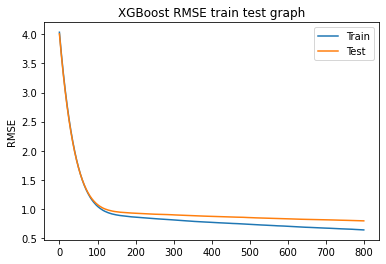

0:04:23.017921
----------------------------------------------------------------------------------------------------


[0.6413237709473282, 0.7935520975795592]

In [76]:
regressor(X_train.drop(['vendor_rating_x','bslpr'],axis=1), X_test.drop(['vendor_rating_x','bslpr'],axis=1), y_train, y_test ,'SVD model',False)

### Regression with xgboost and knn

In [77]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=10, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:06.304923 

Evaluating the model with train data..
time taken : 0:00:25.690345
---------------
Train Data
---------------
RMSE : 0.4910039126020711

MAPE : 9.951418829635998

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:06.470353
---------------
Test Data
---------------
RMSE : 0.6614684124732495

MAPE : 14.366878546529204

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:38.466939


In [78]:
X_train['knn_u']=models_evaluation_train['knn_bsl_u']['predictions']
X_test['knn_u']=models_evaluation_test['knn_bsl_u']['predictions']

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:03:59.733001
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


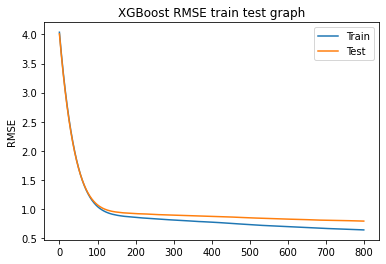

0:04:14.766055
----------------------------------------------------------------------------------------------------


[0.6480757753738614, 0.7956662884368232]

In [79]:
regressor(X_train.drop(['vendor_rating_x','bslpr','svdpp'],axis=1), X_test.drop(['vendor_rating_x','bslpr','svdpp'],axis=1), y_train, y_test ,'knn model',False)

### all surprise features

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:03:57.437120
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


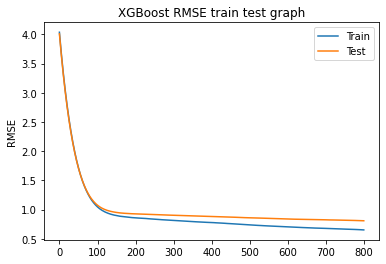

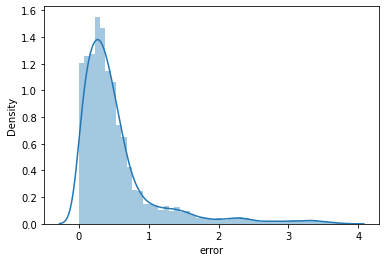

----------------------------------------------------------------------------------------------------


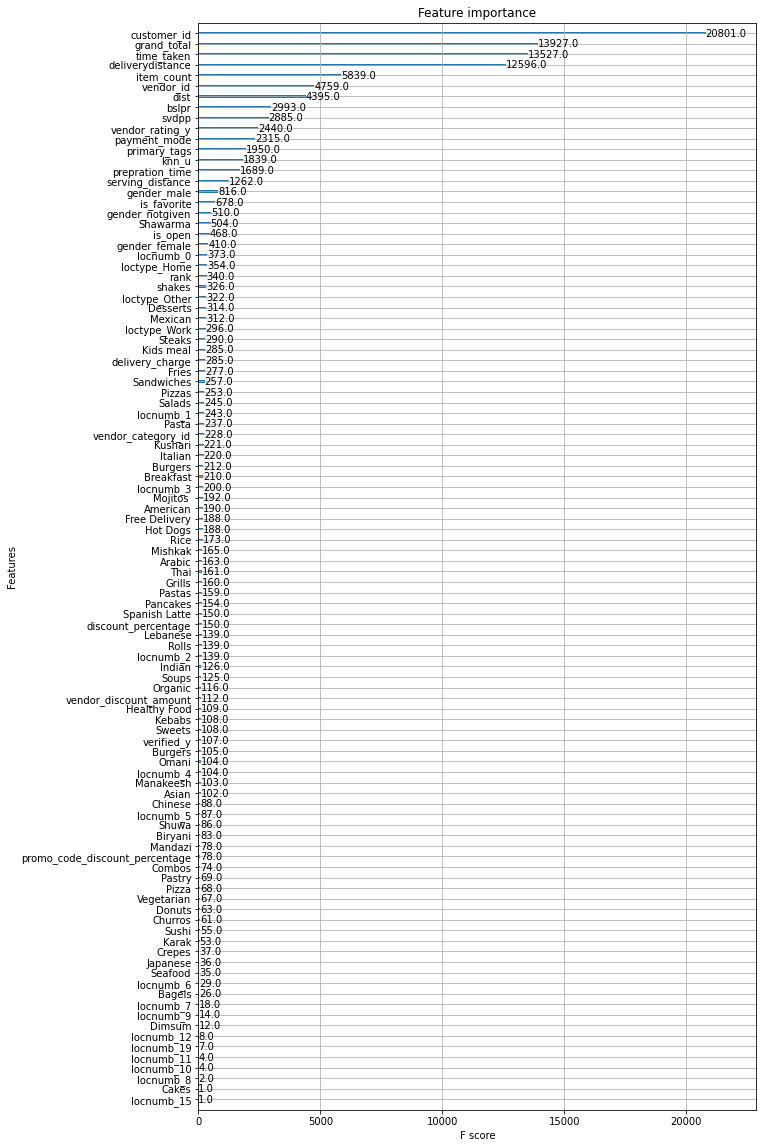

0:04:14.388325
----------------------------------------------------------------------------------------------------


[0.6553402701164466, 0.8070701554616005]

In [80]:
regressor(X_train.drop(['vendor_rating_x'],axis=1), X_test.drop(['vendor_rating_x'],axis=1), y_train, y_test ,'surprise features',True)

## feature selection

Fitting 3 folds for each of 8 candidates, totalling 24 fits
time required to tune hyperparamter     0:02:42.849765
****************************************************************************************************
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=15,
             reg_alpha=0, reg_lambda=1, ...)
****************************************************************************************************


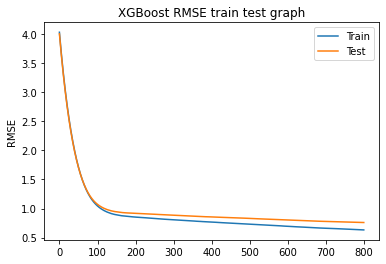

0:02:51.660245
----------------------------------------------------------------------------------------------------


[0.6319388668844097, 0.7590906621242676]

In [81]:
x_train, x_test, y_train, y_test = train_test_split(final1[['customer_id','grand_total','time_taken','deliverydistance','vendor_rating_y','vendor_id']], final1.vendor_rating_x, test_size=0.20,random_state=15)
regressor(x_train, x_test, y_train, y_test ,'selected features',False)

[0.8597408764553838, 0.9166745544300888]

## plotting results

In [82]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Train RMSE','Test RMSE']
x.add_row(['raw model',rmse['raw model'][0], rmse['raw model'][1]]) 
x.add_row(['baseline model',rmse['baseline model'][0], rmse['baseline model'][1]])
x.add_row(['knn model',rmse['knn model'][0],rmse['knn model'][1]])
x.add_row(['SVD model',rmse['SVD model'][0], rmse['SVD model'][1]])
x.add_row(['surprise features',rmse['surprise features'][0], rmse['surprise features'][1]])
x.add_row(['selected features',rmse['selected features'][0], rmse['selected features'][1]])

print(x)

+-------------------+--------------------+--------------------+
|       Model       |     Train RMSE     |     Test RMSE      |
+-------------------+--------------------+--------------------+
|     raw model     | 0.6452332043639201 | 0.7880284038981112 |
|   baseline model  | 0.6508886768436781 | 0.7964104571409063 |
|     knn model     | 0.6480757753738614 | 0.7956662884368232 |
|     SVD model     | 0.6413237709473282 | 0.7935520975795592 |
| surprise features | 0.6553402701164466 | 0.8070701554616005 |
| selected features | 0.6319388668844097 | 0.7590906621242676 |
+-------------------+--------------------+--------------------+


**We can see models with even selected features**

---


**customer_id,grand_total,time_taken,deliverydistance even perform well than others with more features thus collaborative filtering can take place on these features only**

In [83]:
X_train[['vendor_rating_x','bslpr','svdpp','knn_u']].iloc[60:80]

,vendor_rating_x,bslpr,svdpp,knn_u
10656,5.0,5.000000,4.927010,5.000000
35843,5.0,5.000000,5.000000,4.700000
48156,5.0,5.000000,4.927010,5.000000
29884,5.0,5.000000,4.927010,5.000000
27001,4.0,5.000000,5.000000,4.700000
31449,5.0,5.000000,5.000000,4.700000
19381,5.0,4.933079,4.994192,4.987008
38940,5.0,5.000000,4.927010,5.000000
31571,5.0,4.604218,4.781894,4.910781
48395,5.0,5.000000,4.927010,5.000000


**table above is showing that why is it so that more features are disturbing RMSE values**

## Now we will be using our selected features and build user user similarity matrix and also try vendor vendor similarity matrix and based on these matrics we will try predicting next most similar vendors. what we can also do is leverage vendor rating already give and use refer only most rated vendors ie vendors with average rating greater than 4

## Collaborative filtering similarity based

### customer-customer similarity

In [84]:
# here we not only rely on our rating parameter but instead go out and use all parameters available
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
cus_scaler=StandardScaler()
x=final1[['customer_id','grand_total','time_taken','deliverydistance','vendor_rating_y','vendor_rating_x']]
cust_sim=x.groupby(['customer_id']).mean()
cust_sim1=cus_scaler.fit_transform(cust_sim)
a=np.zeros((7521,100))
for i in tqdm(range(100)):  #this can be taken to 7521 but for time constraint taking it till 100 only
  for j in range(len(cust_sim1)):
    a[j][i]=cosine_similarity([cust_sim1[i],cust_sim1[j]]).min()
customer_sim=pd.DataFrame(a)
del a
customer_sim

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.097947,0.682861,0.807216,0.768810,0.546445,0.695962,0.363478,0.837352,0.154456,...,0.666320,-0.050361,0.282547,-0.312600,0.592128,0.524790,0.983174,0.217482,-0.184385,-0.063693
1,0.097947,1.000000,0.782042,-0.082187,0.549931,0.085118,-0.206253,-0.160713,0.433000,-0.044059,...,0.347019,-0.274259,-0.206415,-0.677040,0.263229,-0.104654,0.136813,-0.083233,0.087636,0.187762
2,0.682861,0.782042,1.000000,0.487064,0.838809,0.491989,0.252347,0.141012,0.795477,-0.024489,...,0.672384,-0.141024,0.112109,-0.635644,0.587007,0.223491,0.717751,0.010816,0.034526,0.154413
3,0.807216,-0.082187,0.487064,1.000000,0.517863,0.852499,0.286520,0.601634,0.649221,0.150928,...,0.806378,0.536080,0.743553,0.187051,0.792648,0.547351,0.810060,-0.335288,0.327381,0.432986
4,0.768810,0.549931,0.838809,0.517863,1.000000,0.410156,0.287845,0.444812,0.845205,0.264909,...,0.689209,-0.145346,0.163101,-0.433073,0.726903,0.192695,0.703156,0.132399,0.005695,0.153980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516,0.300047,0.377336,0.514859,0.108751,0.057288,0.188721,0.494203,-0.444459,0.169277,-0.602562,...,-0.025838,-0.316744,-0.192104,-0.633179,-0.195903,0.084167,0.455374,0.291350,-0.298935,-0.386984
7517,-0.149527,0.003692,-0.165042,-0.510848,0.194323,-0.439091,0.097604,0.159674,-0.233801,-0.070959,...,-0.495559,-0.495272,-0.370009,-0.106006,-0.175786,-0.640077,-0.263334,0.648112,-0.258231,-0.402979
7518,0.328863,-0.447034,-0.066700,0.253064,-0.262671,0.193562,0.723236,-0.168500,-0.121528,-0.565736,...,-0.264556,-0.085941,0.044749,-0.063286,-0.299475,0.129180,0.431886,0.420094,-0.349365,-0.533306
7519,0.192052,-0.485602,-0.163235,0.201781,-0.380672,0.225579,0.586979,-0.125327,-0.275665,-0.659636,...,-0.342057,0.032762,0.124952,0.068361,-0.315195,0.007001,0.303399,0.326593,-0.211807,-0.444603


In [85]:
customer_numb=4
for i in customer_sim.nlargest(10, [customer_numb]).index:
  print('vendor rating average given in vendor.csv {:0.2f},  rating acc to orders {:0.2f},    similarity score {:0.5f}   with index numb {}'.format(cust_sim.vendor_rating_y.iloc[i],cust_sim.vendor_rating_x.iloc[i],customer_sim[customer_numb].iloc[i],i))

vendor rating average given in vendor.csv 4.53,  rating acc to orders 4.56,    similarity score 1.00000   with index numb 4
vendor rating average given in vendor.csv 4.70,  rating acc to orders 5.00,    similarity score 0.98771   with index numb 361
vendor rating average given in vendor.csv 4.70,  rating acc to orders 5.00,    similarity score 0.98164   with index numb 188
vendor rating average given in vendor.csv 4.70,  rating acc to orders 5.00,    similarity score 0.97822   with index numb 2469
vendor rating average given in vendor.csv 4.62,  rating acc to orders 5.00,    similarity score 0.97695   with index numb 164
vendor rating average given in vendor.csv 4.70,  rating acc to orders 4.67,    similarity score 0.97446   with index numb 407
vendor rating average given in vendor.csv 4.70,  rating acc to orders 5.00,    similarity score 0.97334   with index numb 1196
vendor rating average given in vendor.csv 4.47,  rating acc to orders 4.50,    similarity score 0.97328   with index n

### Vendor-vendor similarity

In [86]:
#here we will obtain vendor vendor similarity
scaler = StandardScaler()
x=final1[['vendor_id','grand_total','time_taken','deliverydistance','vendor_rating_y','vendor_rating_x']]
vendor_sim=x.groupby(['vendor_id']).mean()
vendor_sim1=scaler.fit_transform(vendor_sim)
a=np.zeros((100,100))
for i in range(len(vendor_sim1)):
  for j in range(len(vendor_sim1)):
    a[i][j]=cosine_similarity([vendor_sim1[i],vendor_sim1[j]]).min()
vend_sim=pd.DataFrame(a)
del a
vend_sim

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.382488,-0.429054,0.294958,-0.545677,-0.343252,-0.901071,-0.630957,-0.758379,-0.267468,...,0.521193,0.330128,0.202054,-0.273402,0.033930,0.070878,-0.586070,0.584824,0.551396,0.181810
1,0.382488,1.000000,0.228075,0.717192,0.334709,0.637253,-0.151788,-0.241878,0.287652,-0.076897,...,-0.191285,-0.408791,-0.010548,-0.531800,-0.718407,-0.684704,-0.432451,-0.070159,-0.225879,-0.044699
2,-0.429054,0.228075,1.000000,0.635377,0.315465,0.765307,0.275549,0.062250,0.611806,-0.335013,...,0.161406,-0.834223,-0.828300,-0.710947,-0.796411,-0.757464,-0.448865,-0.975805,-0.909866,-0.632755
3,0.294958,0.717192,0.635377,1.000000,-0.062935,0.645326,-0.378365,-0.571189,0.158588,-0.168859,...,0.291688,-0.454355,-0.502176,-0.791397,-0.773882,-0.706701,-0.834037,-0.517483,-0.413689,-0.626345
4,-0.545677,0.334709,0.315465,-0.062935,1.000000,0.518103,0.790912,0.802144,0.793373,-0.136615,...,-0.594796,-0.623296,-0.153820,-0.114811,-0.501634,-0.590822,0.395056,-0.299776,-0.647431,0.376664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.070878,-0.684704,-0.757464,-0.706701,-0.590822,-0.745156,-0.158104,-0.164478,-0.538102,0.507729,...,-0.069081,0.860084,0.677460,0.844406,0.978948,1.000000,0.499914,0.629216,0.831551,0.154346
96,-0.586070,-0.432451,-0.448865,-0.834037,0.395056,-0.216084,0.717527,0.646836,0.313609,0.500996,...,-0.757105,0.283539,0.586686,0.847496,0.558106,0.499914,1.000000,0.303381,0.207709,0.466895
97,0.584824,-0.070159,-0.975805,-0.517483,-0.299776,-0.716599,-0.381407,-0.106475,-0.652364,0.189319,...,-0.076134,0.745289,0.781750,0.549452,0.662534,0.629216,0.303381,1.000000,0.881249,0.679686
98,0.551396,-0.225879,-0.909866,-0.413689,-0.647431,-0.717799,-0.518565,-0.439905,-0.734912,0.439413,...,0.008620,0.916566,0.793601,0.637866,0.807880,0.831551,0.207709,0.881249,1.000000,0.274760


In [87]:
# lets check this with vendor rating of vendor_id 4
vendor_id=4
for i in vend_sim.nlargest(10, [vendor_id]).index:
  #print(vendor_sim.iloc[i])
  print('vendor rating average given in vendor.csv {:0.2f},  rating acc to orders {:0.2f},    similarity score {:0.5f},  with index numb {}'.format(vendor_sim.vendor_rating_y.iloc[i],vendor_sim.vendor_rating_x.iloc[i],vend_sim[vendor_id].iloc[i],i))

vendor rating average given in vendor.csv 4.40,  rating acc to orders 4.58,    similarity score 1.00000,  with index numb 4
vendor rating average given in vendor.csv 4.50,  rating acc to orders 4.63,    similarity score 0.98098,  with index numb 77
vendor rating average given in vendor.csv 4.50,  rating acc to orders 4.54,    similarity score 0.90145,  with index numb 23
vendor rating average given in vendor.csv 4.50,  rating acc to orders 4.50,    similarity score 0.87675,  with index numb 24
vendor rating average given in vendor.csv 4.50,  rating acc to orders 4.43,    similarity score 0.87293,  with index numb 33
vendor rating average given in vendor.csv 4.60,  rating acc to orders 4.61,    similarity score 0.87109,  with index numb 82
vendor rating average given in vendor.csv 4.40,  rating acc to orders 4.61,    similarity score 0.84668,  with index numb 21
vendor rating average given in vendor.csv 4.60,  rating acc to orders 4.52,    similarity score 0.81435,  with index numb 56
v

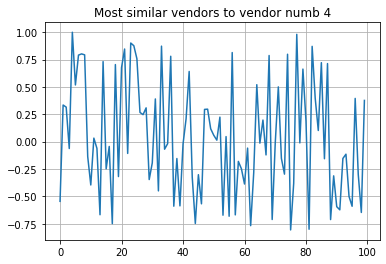

In [88]:
a=[]
for i in range(len(vend_sim)):
  a.append(i)
plt.plot(a,vend_sim[4])
plt.title("Most similar vendors to vendor numb 4")
plt.grid()

### Customer vendor rating realtionship

In [89]:
ratings = final1[['customer_id', 'vendor_id', 'vendor_rating_x']].astype(int)
ratings.rename(columns={'customer_id':'customer_idx', 'vendor_id':'vendor_idx', 'vendor_rating_x':'rating'}, inplace=True)
ratings = ratings.groupby(['customer_idx', 'vendor_idx']).mean().reset_index()
rating_full_matrix_by_index_with_nan = ratings.pivot(index='customer_idx', columns='vendor_idx', values='rating')
rating_full_matrix_by_index_with_nan

vendor_idx,4,13,20,23,28,33,43,44,55,66,...,681,841,843,845,846,849,855,856,858,907
customer_idx,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
7517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
7518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


<AxesSubplot:ylabel='count'>

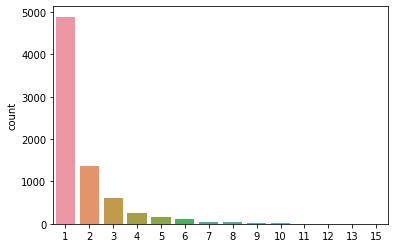

In [90]:
sns.countplot(rating_full_matrix_by_index_with_nan.notnull().sum(axis=1))

This shows that user voted for max 15 vendors and data looks healthy

## Testing the model

In [91]:
from collections import Counter
def get_vendor(cust_id):
  k=customer_sim.nlargest(4, [cust_id])
  #print(k)
  vendor_list=[]
  for i in range(1,len(k)):
    vendor_list.append(final1.vendor_id[final1.customer_id==i].unique())
  a=[]
  for i in range(3):
    for j in vendor_list[i]:
      a.append(j)
  return Counter(a).most_common()

k=4
a=get_vendor(k)
count=0;inc=1
venlist=[]
print("*"*100)
print("top recommended vendors are")
print("*"*100)
while len(venlist)<3:
  try:
    if (final.vendor_rating_x[(final1.customer_id==k) & (final1.vendor_id==a[count][0])].mean()) > 4:
      venlist.append(str(inc)+' you can go for vendor with id : '+str(a[count][0]))
      inc+=1
    count+=1
  except:
    break
for i in venlist:
  print(i)

****************************************************************************************************
top recommended vendors are
****************************************************************************************************
1 you can go for vendor with id : 113
2 you can go for vendor with id : 298
3 you can go for vendor with id : 310
